<a href="https://colab.research.google.com/github/game-sys/IADS_Transfer_Learning/blob/main/3_Fine_Tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# models
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow
from keras.applications import MobileNet
from keras.applications import ResNet50
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
import sklearn.metrics as metrics
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard

In [2]:

os.environ['KAGGLE_USERNAME'] = "mohsin525" # username from the json file
os.environ['KAGGLE_KEY'] = "0354188f768ecafd675cd5409ca85604" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle (https://www.kaggle.com/c/dogs-vs-cats/data)

100% 809M/812M [00:38<00:00, 24.3MB/s]
100% 812M/812M [00:38<00:00, 22.2MB/s]


In [3]:
from zipfile import ZipFile
file_name = "/content/dogs-vs-cats.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('All Files Extracted !')





All Files Extracted !


In [4]:
from zipfile import ZipFile
file_name = "/content/train.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('All Files Extracted !')


All Files Extracted !


In [5]:
# Get all the paths
data_dir_list = os.listdir('/content/train')
#print(data_dir_list)
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print(file_count)

25000


In [6]:
import os
import shutil
data_dir = '/content/'
categories = ['cat', 'dog']


for category in categories:
    category_dir = os.path.join(data_dir, category)
    print(category_dir)
    os.makedirs(category_dir, exist_ok=True)

/content/cat
/content/dog


In [7]:
data_dir = '/content/'
train_dir = '/content/train'
count=0
for category in categories:
    category_dir = os.path.join(data_dir, category)
    label = categories.index(category)

    for img_file in os.listdir(train_dir):
        if img_file.startswith(category):
          src_path = os.path.join(train_dir, img_file)
          dst_path = os.path.join(category_dir, img_file)
          if not os.path.exists(dst_path):
              shutil.copy(src_path, dst_path)
              count+=1
        else:
          print(f"File '{img_file}' already exists in '{category}' folder. Skipping.")

print(f'Copied {count} files')

Streaming output truncated to the last 5000 lines.
File 'cat.11029.jpg' already exists in 'dog' folder. Skipping.
File 'cat.9901.jpg' already exists in 'dog' folder. Skipping.
File 'cat.3471.jpg' already exists in 'dog' folder. Skipping.
File 'cat.8207.jpg' already exists in 'dog' folder. Skipping.
File 'cat.11974.jpg' already exists in 'dog' folder. Skipping.
File 'cat.11130.jpg' already exists in 'dog' folder. Skipping.
File 'cat.7365.jpg' already exists in 'dog' folder. Skipping.
File 'cat.11994.jpg' already exists in 'dog' folder. Skipping.
File 'cat.10616.jpg' already exists in 'dog' folder. Skipping.
File 'cat.1453.jpg' already exists in 'dog' folder. Skipping.
File 'cat.1849.jpg' already exists in 'dog' folder. Skipping.
File 'cat.11030.jpg' already exists in 'dog' folder. Skipping.
File 'cat.10012.jpg' already exists in 'dog' folder. Skipping.
File 'cat.4539.jpg' already exists in 'dog' folder. Skipping.
File 'cat.1568.jpg' already exists in 'dog' folder. Skipping.
File 'cat.83

In [8]:
path, dirs, files = next(os.walk("/content/cat"))
file_count = len(files)
print(file_count)

path, dirs, files = next(os.walk("/content/dog"))
file_count = len(files)
print(file_count)

12500
12500


In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = '/content/'
categories = ['cat', 'dog']
IMG_SIZE=80
image_size = (IMG_SIZE, IMG_SIZE)  # Set the desired image size (width, height).

images = []
labels = []

# Load the images and labels
for category in categories:
    category_dir = os.path.join(data_dir, category)
    label = categories.index(category)

    for img_file in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, image_size)
        images.append(img)
        labels.append(label)

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Perform data splitting: 70% train, 20% test, 10% validation
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Print the shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)


X_train shape: (17500, 80, 80, 3)
X_test shape: (5025, 80, 80, 3)
X_val shape: (2475, 80, 80, 3)
y_train shape: (17500,)
y_test shape: (5025,)
y_val shape: (2475,)


In [10]:
# One-hot encode the labels
num_classes = 2  # For binary classification (cat and dog).
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

In [29]:
def ResNET50():
    print("Loading ResNet50 Model...")
    # Load the ResNet50 model with pre-trained weights, excluding the top layers
    base_model = ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=(80, 80, 3))

    # Freeze the layers up to a certain point (fine-tuning)
    freeze_until_layer = 160 # Freeze layers
    for layer in base_model.layers[:freeze_until_layer]:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])


    # Print the layers and their trainable status in the base model
    for i, layer in enumerate(base_model.layers):
        print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")


    model.summary()

    return model





In [30]:
model=ResNET50()

Loading ResNet50 Model...
Layer 0: input_9 - Trainable: False
Layer 1: conv1_pad - Trainable: False
Layer 2: conv1_conv - Trainable: False
Layer 3: conv1_bn - Trainable: False
Layer 4: conv1_relu - Trainable: False
Layer 5: pool1_pad - Trainable: False
Layer 6: pool1_pool - Trainable: False
Layer 7: conv2_block1_1_conv - Trainable: False
Layer 8: conv2_block1_1_bn - Trainable: False
Layer 9: conv2_block1_1_relu - Trainable: False
Layer 10: conv2_block1_2_conv - Trainable: False
Layer 11: conv2_block1_2_bn - Trainable: False
Layer 12: conv2_block1_2_relu - Trainable: False
Layer 13: conv2_block1_0_conv - Trainable: False
Layer 14: conv2_block1_3_conv - Trainable: False
Layer 15: conv2_block1_0_bn - Trainable: False
Layer 16: conv2_block1_3_bn - Trainable: False
Layer 17: conv2_block1_add - Trainable: False
Layer 18: conv2_block1_out - Trainable: False
Layer 19: conv2_block2_1_conv - Trainable: False
Layer 20: conv2_block2_1_bn - Trainable: False
Layer 21: conv2_block2_1_relu - Trainable

In [ ]:
import matplotlib.pyplot as plt


# Define the paths for saving the model and TensorBoard logs
model_name = "ResNet50_CatvsDog"
model_dir = "models"


print("Starting Training... ")



# Train the model using the one-hot encoded labels and store the history
history = model.fit(X_train, y_train_one_hot, epochs=5, batch_size=128, validation_data=(X_val, y_val_one_hot),
                    callbacks=[ModelCheckpoint(os.path.join(model_dir, model_name + ".h5"),
                                               save_best_only=True)])





Starting Training... 
Epoch 1/5
137/137 [==============================] - 31s 112ms/step - loss: 0.3814 - accuracy: 0.8287 - val_loss: 0.3307 - val_accuracy: 0.8537
Epoch 2/5
137/137 [==============================] - 11s 83ms/step - loss: 0.2541 - accuracy: 0.8917 - val_loss: 0.3047 - val_accuracy: 0.8626
Epoch 3/5
137/137 [==============================] - 12s 90ms/step - loss: 0.2063 - accuracy: 0.9146 - val_loss: 0.2983 - val_accuracy: 0.8687
Epoch 4/5
137/137 [==============================] - 12s 85ms/step - loss: 0.1639 - accuracy: 0.9365 - val_loss: 0.2911 - val_accuracy: 0.8731
Epoch 5/5
137/137 [==============================] - 11s 80ms/step - loss: 0.1330 - accuracy: 0.9540 - val_loss: 0.3009 - val_accuracy: 0.8723


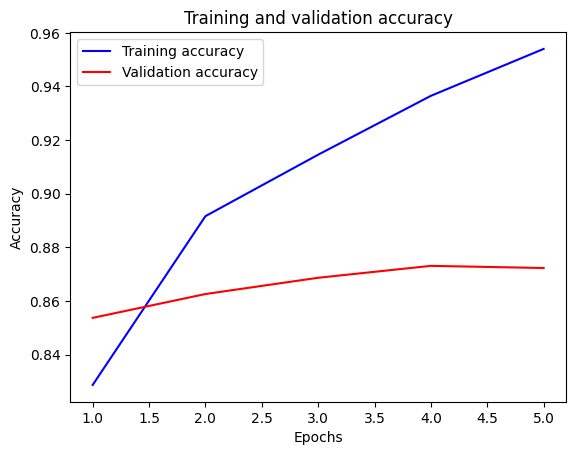

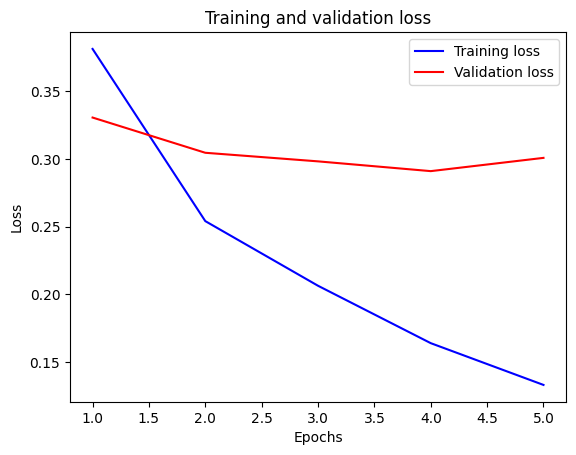

In [ ]:
# Plot training and validation accuracy on the same plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss on the same plot
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

# Load the saved model
saved_model_path = "models/ResNet50_CatvsDog.h5"
loaded_model = load_model(saved_model_path)

# Evaluate the model on the test data
loss, accuracy = loaded_model.evaluate(X_test, y_test_one_hot, batch_size=128)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 4s 73ms/step - loss: 0.2897 - accuracy: 0.8818
Test Loss: 0.28969499468803406
Test Accuracy: 0.8817910552024841


In [31]:

def MobileNet_model():
    print("Loading MobileNet Model...")
    # Load the MobileNet model with pre-trained weights, excluding the top layers
    base_model = MobileNet(include_top=False, weights='imagenet', pooling='avg', input_shape=(80, 80, 3))

    # Freeze the layers up to a certain point (fine-tuning)
    freeze_until_layer = 50  # Freeze layers
    for layer in base_model.layers[:freeze_until_layer]:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Dense(2, activation='softmax'))

    # Compile the model with your desired optimizer, loss function, and metrics
    optimizer = 'adam'  # Example optimizer, adjust as needed
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # Print the layers and their trainable status in the base model
    for i, layer in enumerate(base_model.layers):
        print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")


    model.summary()

    return model

In [32]:
model=MobileNet_model()

Loading MobileNet Model...
17225924/17225924 [==============================] - 2s 0us/step
Layer 0: input_10 - Trainable: False
Layer 1: conv1 - Trainable: False
Layer 2: conv1_bn - Trainable: False
Layer 3: conv1_relu - Trainable: False
Layer 4: conv_dw_1 - Trainable: False
Layer 5: conv_dw_1_bn - Trainable: False
Layer 6: conv_dw_1_relu - Trainable: False
Layer 7: conv_pw_1 - Trainable: False
Layer 8: conv_pw_1_bn - Trainable: False
Layer 9: conv_pw_1_relu - Trainable: False
Layer 10: conv_pad_2 - Trainable: False
Layer 11: conv_dw_2 - Trainable: False
Layer 12: conv_dw_2_bn - Trainable: False
Layer 13: conv_dw_2_relu - Trainable: False
Layer 14: conv_pw_2 - Trainable: False
Layer 15: conv_pw_2_bn - Trainable: False
Layer 16: conv_pw_2_relu - Trainable: False
Layer 17: conv_dw_3 - Trainable: False
Layer 18: conv_dw_3_bn - Trainable: False
Layer 19: conv_dw_3_relu - Trainable: False
Layer 20: conv_pw_3 - Trainable: False
Layer 21: conv_pw_3_bn - Trainable: False
Layer 22: conv_pw_3_r

In [ ]:

# Define the paths for saving the model and TensorBoard logs
model_name = "MobileNet_CatvsDog"
model_dir = "models"

print("Starting Training... ")

# Train the model using the one-hot encoded labels
history = model.fit(X_train, y_train_one_hot, epochs=5, batch_size=128, validation_data=(X_val, y_val_one_hot),
                    callbacks=[ModelCheckpoint(os.path.join(model_dir, model_name + ".h5"),
                                               save_best_only=True,
                                               )])


Starting Training... 
Epoch 1/5
137/137 [==============================] - 16s 52ms/step - loss: 0.7319 - accuracy: 0.7147 - val_loss: 0.7295 - val_accuracy: 0.7446
Epoch 2/5
137/137 [==============================] - 6s 45ms/step - loss: 0.3749 - accuracy: 0.8296 - val_loss: 0.5194 - val_accuracy: 0.7608
Epoch 3/5
137/137 [==============================] - 6s 43ms/step - loss: 0.2693 - accuracy: 0.8810 - val_loss: 0.7451 - val_accuracy: 0.7523
Epoch 4/5
137/137 [==============================] - 6s 44ms/step - loss: 0.2160 - accuracy: 0.9102 - val_loss: 0.7043 - val_accuracy: 0.7491
Epoch 5/5
137/137 [==============================] - 6s 44ms/step - loss: 0.1771 - accuracy: 0.9278 - val_loss: 0.7863 - val_accuracy: 0.7463


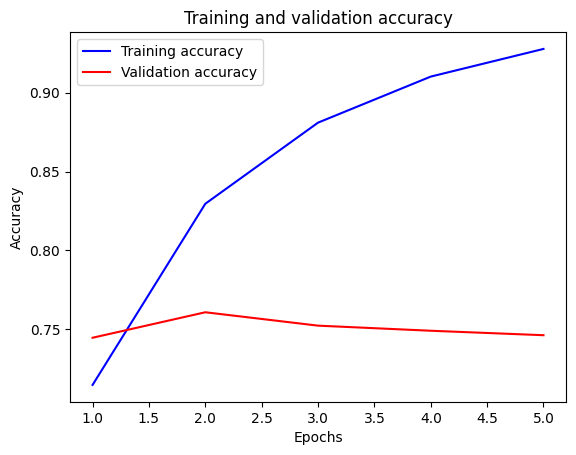

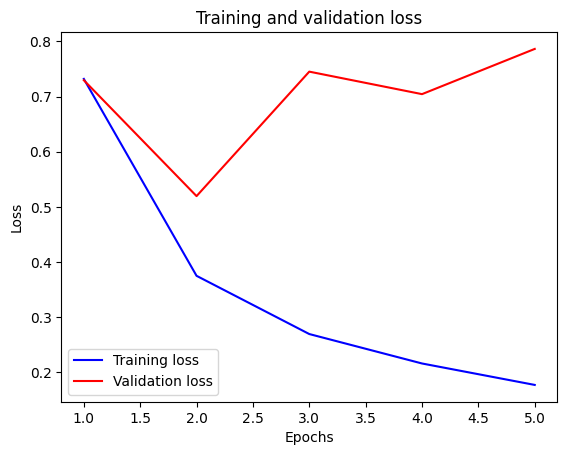

In [ ]:
# Plot training and validation accuracy on the same plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss on the same plot
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

# Load the saved model
saved_model_path = "models/MobileNet_CatvsDog.h5"
loaded_model = load_model(saved_model_path)

# Evaluate the model on the test data
loss, accuracy = loaded_model.evaluate(X_test, y_test_one_hot, batch_size=128)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 1s 22ms/step - loss: 0.5231 - accuracy: 0.7638
Test Loss: 0.5231021046638489
Test Accuracy: 0.7637810707092285
